In [ ]:
#|default_exp callback.lr_finder

In [ ]:
#|exporti
# Contains code from:
# fastai - Apache License 2.0 - Copyright (c) 2023 fast.ai

# Learning Rate Finder
> Learning rate finder modified to restore dataloader and random state after running

When finished running, fastai's [learning rate finder](https://docs.fast.ai/callback.schedule.html#lrfinder) only restores the model weights and optimizer to the initial state.

By default, fastxtend's learning rate finder additionally restores the dataloader and random state to their inital state, so running `Learner.lr_find` has no effect on model training.

In [ ]:
#|export
from fastcore.xtras import is_listy
from fastcore.foundation import patch, docs, Path
from fastcore.basics import tuplify
from fastai.callback.schedule import ParamScheduler, SchedExp, SuggestionMethod
from fastai.torch_core import tensor, get_random_states, set_random_states
from fastai.learner import Learner, CancelFitException, CancelValidException
from functools import partial
from copy import deepcopy
import torch
import collections, tempfile

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
@docs
class LRFinder(ParamScheduler):
    "Training with exponentially growing learning rate"
    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, restore_state=True):
        if num_it < 6: num_it = 6
        self.scheds = {'lr': [SchedExp(s, e) for (s,e) in zip(start_lr,end_lr)
                             ] if is_listy(start_lr) else SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div,self.restore_state = num_it,stop_div,restore_state

    def before_fit(self):
        "Initialize container for hyper-parameters and save the model & optimizer, optionally saving dataloader & random state"
        super().before_fit()
        if self.restore_state:
            self.old_dls = deepcopy(self.learn.dls)
            self.states = get_random_states()
        path = self.path/self.model_dir
        path.mkdir(parents=True, exist_ok=True)
        self.tmp_d = tempfile.TemporaryDirectory(dir=path)
        self.tmp_p = Path(self.tmp_d.name).stem
        self.learn.save(f'{self.tmp_p}/_tmp')
        self.best_loss = float('inf')

    def before_batch(self):
        "Set the proper hyper-parameters in the optimizer"
        self._update_val(self.train_iter/self.num_it)

    def after_batch(self):
        "Record hyper-parameters of this batch and potentially stop training"
        super().after_batch()
        if self.smooth_loss < self.best_loss: self.best_loss = self.smooth_loss
        if self.smooth_loss > 4*self.best_loss and self.stop_div: raise CancelFitException()
        if self.train_iter >= self.num_it: raise CancelFitException()

    def before_validate(self):
        "Skip the validation part of training"
        raise CancelValidException()

    def after_fit(self):
        "Save the hyper-parameters in the recorder if there is one and load the original model & optimizer, optionally restoring dataloader & random state"
        self.learn.opt.zero_grad() # Needed before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/self.tmp_p/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load(f'{self.tmp_p}/_tmp', with_opt=True)
            self.tmp_d.cleanup()
        if self.restore_state:
            self.learn.dls = self.old_dls
            set_random_states(**self.states)

In [ ]:
#|hide
#|slow
from fastcore.basics import range_of

from fastxtend.imports import *
from fastxtend.test_utils import *

In [ ]:
#|hide
#|slow
with tempfile.TemporaryDirectory() as d:
    learn = synth_learner(path=Path(d))
    init_a,init_b,init_s= learn.model.a,learn.model.b,get_random_states()
    with learn.no_logging(): learn.fit(20, cbs=LRFinder(num_it=100))
    assert len(learn.recorder.lrs) <= 100
    test_eq(len(learn.recorder.lrs), len(learn.recorder.losses))
    #Check stop if diverge
    if len(learn.recorder.lrs) < 100: assert learn.recorder.losses[-1] > 4 * min(learn.recorder.losses)
    #Test schedule
    test_eq(learn.recorder.lrs, [SchedExp(1e-7, 10)(i/100) for i in range_of(learn.recorder.lrs)])
    #No validation data
    test_eq([len(v) for v in learn.recorder.values], [1 for _ in range_of(learn.recorder.values)])
    #Model loaded back properly
    test_eq(learn.model.a, init_a)
    test_eq(learn.model.b, init_b)
    test_eq(learn.opt.state_dict()['state'], [{}, {}])
    test_eq(init_s.items(), get_random_states().items())

In [ ]:
show_doc(LRFinder.before_fit)

<h4 id="LRFinder.before_fit" class="doc_header"><code>LRFinder.before_fit</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.before_fit</code>()

Initialize container for hyper-parameters and save the model & optimizer, optionally saving dataloader & random state

In [ ]:
show_doc(LRFinder.before_batch)

<h4 id="LRFinder.before_batch" class="doc_header"><code>LRFinder.before_batch</code><a href="__main__.py#L23" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.before_batch</code>()

Set the proper hyper-parameters in the optimizer

In [ ]:
show_doc(LRFinder.after_batch)

<h4 id="LRFinder.after_batch" class="doc_header"><code>LRFinder.after_batch</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.after_batch</code>()

Record hyper-parameters of this batch and potentially stop training

In [ ]:
show_doc(LRFinder.before_validate)

<h4 id="LRFinder.before_validate" class="doc_header"><code>LRFinder.before_validate</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.before_validate</code>()

Skip the validation part of training

In [ ]:
show_doc(LRFinder.after_fit)

<h4 id="LRFinder.after_fit" class="doc_header"><code>LRFinder.after_fit</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.after_fit</code>()

Save the hyper-parameters in the recorder if there is one and load the original model & optimizer, optionally restoring dataloader & random state

## lr_find -

In [ ]:
#|export
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley), restore_state=True):
    """
    Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple.

    Use `restore_state` to reset dataloaders and random state after running.
    """
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div,restore_state=restore_state)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if suggest_funcs is not None:
        lrs, losses = tensor(self.recorder.lrs[num_it//10:-5]), tensor(self.recorder.losses[num_it//10:-5])
        nan_idxs = torch.nonzero(torch.isnan(losses.view(-1)))
        if len(nan_idxs) > 0:
            drop_idx = min(nan_idxs)
            lrs = lrs[:drop_idx]
            losses = losses[:drop_idx]
        _suggestions, nms = [], []
        for func in tuplify(suggest_funcs):
            nms.append(func.__name__ if not isinstance(func, partial) else func.func.__name__) # deal with partials
            _suggestions.append(func(lrs, losses, num_it))

        SuggestedLRs = collections.namedtuple('SuggestedLRs', nms)
        lrs, pnts = [], []
        for lr, pnt in _suggestions:
            lrs.append(lr)
            pnts.append(pnt)
        if show_plot: self.recorder.plot_lr_find(suggestions=pnts, nms=nms)
        return SuggestedLRs(*lrs)

    elif show_plot: self.recorder.plot_lr_find()

Minimum/10:	1.32e-01
Steepest point:	7.59e-07
Longest valley:	1.58e-02
Slide interval:	6.31e-07


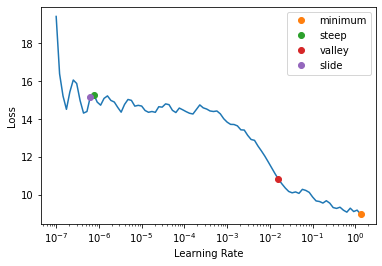

In [ ]:
#|hide
#|slow
with tempfile.TemporaryDirectory() as d:
    learn = synth_learner(path=Path(d))
    weights_pre_lr_find = L(learn.model.parameters())
    lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(SuggestionMethod.Minimum, SuggestionMethod.Steep, SuggestionMethod.Valley, SuggestionMethod.Slide))
    weights_post_lr_find = L(learn.model.parameters())
test_eq(weights_pre_lr_find, weights_post_lr_find)
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

Without `restore_state`, running `lr_find` advances both the random state and DataLoaders and behaves the same way as [fastai's](https://docs.fast.ai/callback.schedule.html#Learner.lr_find) `lr_find`. Which means the following two code blocks will result with different training output.

```python
with no_random():
    dls = get_dls()
    learn = Learner(dls, xresnet18(n_out=dls.c))

with no_random():
    learn.lr_find(restore_state=False)
    learn.fit_one_cycle(2, 3e-3)
```

```python
with no_random():
    dls = get_dls()
    learn = Learner(dls, xresnet18(n_out=dls.c))

with no_random():
    learn.fit_one_cycle(2, 3e-3)
```

While the default of `restore_state=True` prevents this from occurring, it has the potential downside of showing less variance in learning rate results due to every call to `lr_find` will be over the same first `n_iter` items using the same random state.